# Table of Contents

1. [Imports](#imports)
2. [Constants](#constants)
3. [Utils](#utils)
4. [Data preparation](#dataprep)  
    4.1 [Import data](#impdata)  
    4.2 [Set the index](#setind)  
    4.3 [Remove empty columns](#rmcols)  
    4.4 [Datatypes](#datatypes)  
    4.5 [Format Inspection Date](#inspdate)  
    4.6 [Format State](#state)  
    4.7 [Format City](#city)  
    4.8 [Format License # and Zip](#licnzip)  
    4.9 [Columns categorization](#colscateg)  
    4.10 [Format DBA Name and AKA Name](#names)  
    4.11 [Format Address](#addr)  
    4.12 [Extract Violations](#extrviols)  
    4.13 [Pickle the dataframes](#pickle)  
5. [Research questions](#research)  
    5.1 [Load pickled dataframes](#unpickle)  
    5.2 [Inspections' effects on establishments](#effects)  
    5.3 [Establishments' predispositions to inspection failure](#predispositions)  
    5.4 [Neighbourhood and food quality correlation](#neighbourhood)  
    5.5 [Violation analysis](#violation)  

**Remember**: the *Data preparation* and the *Pickle the dataframes* sections need to be executed only once. You can directly jump to the *Research questions* section if you already have the pickled dataframes.

# Imports

<a id="imports"></a>

In [7]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import json
import os
import pickle
from dateutil.parser import parse
from datetime import datetime
sns.set_context('notebook')

# Constants


<a id="constants"></a>

In [8]:
DATA_PATH = './data/food-inspections.csv'
PICKLED_DF_PATH = './data/df.pkl'
PICKLED_DF_VIOLATIONS_PATH = './data/df_violations.pkl'
#DEFAULT_ENCODING = 'UTF8'
#DEFAULT_COMPRESSION = 'gzip'

# Utils


<a id="utils"></a>

In [9]:
def show_all(df):
    """
    Prints the whole DataFrame given as parameter.
    :param df: pandas.DataFrame
    """
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print(df)

# Data preparation


<a id="dataprep"></a>

## Import data


<a id="impdata"></a>

In [10]:
# Import the dataset, adding zero to the list of NaN values.
df = pd.read_csv(DATA_PATH, na_values=[0, 0.0])
df.head(3)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,...,Results,Violations,Latitude,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards
0,2315925,EXOS WORKS,EXOS WORKS,2658207.0,Restaurant,Risk 1 (High),401 N MICHIGAN AVE,CHICAGO,IL,60611.0,...,Pass w/ Conditions,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,41.889354,-87.624102,"{'longitude': '41.88935425192819', 'latitude':...",NaN,NaN,NaN,NaN,NaN
1,2315916,INTRINSIC CHARTER SCHOOL,INTRINSIC CHARTER SCHOOL,3305837.0,School,Risk 1 (High),4540 W BELMONT AVE,CHICAGO,IL,60641.0,...,Fail,59. PREVIOUS PRIORITY FOUNDATION VIOLATION COR...,41.939016,-87.741148,"{'longitude': '41.93901560699069', 'latitude':...",NaN,NaN,NaN,NaN,NaN
2,2315931,STARBUCKS COFFEE #49894,STARBUCKS,2621807.0,Restaurant,Risk 2 (Medium),5601 W LAWRENCE AVE,CHICAGO,IL,60630.0,...,Pass w/ Conditions,"48. WAREWASHING FACILITIES: INSTALLED, MAINTAI...",41.967671,-87.767596,"{'longitude': '41.967671015100265', 'latitude'...",NaN,NaN,NaN,NaN,NaN


## Set the index


<a id="setind"></a>

The column `Inspection ID` should contain distinct values, and thus it represent a natural choice for the index of our dataframe. However, after a quick inspection, we found some duplicates, which we decided to remove.

In [11]:
df.drop_duplicates(subset=['Inspection ID'], inplace=True)
df = df.set_index('Inspection ID')
df.head(3)

,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,...,Results,Violations,Latitude,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards
Inspection ID,,,,,,,,,,,,,,,,,,,,,
2315925,EXOS WORKS,EXOS WORKS,2658207.0,Restaurant,Risk 1 (High),401 N MICHIGAN AVE,CHICAGO,IL,60611.0,2019-10-16T00:00:00.000,...,Pass w/ Conditions,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,41.889354,-87.624102,"{'longitude': '41.88935425192819', 'latitude':...",NaN,NaN,NaN,NaN,NaN
2315916,INTRINSIC CHARTER SCHOOL,INTRINSIC CHARTER SCHOOL,3305837.0,School,Risk 1 (High),4540 W BELMONT AVE,CHICAGO,IL,60641.0,2019-10-16T00:00:00.000,...,Fail,59. PREVIOUS PRIORITY FOUNDATION VIOLATION COR...,41.939016,-87.741148,"{'longitude': '41.93901560699069', 'latitude':...",NaN,NaN,NaN,NaN,NaN
2315931,STARBUCKS COFFEE #49894,STARBUCKS,2621807.0,Restaurant,Risk 2 (Medium),5601 W LAWRENCE AVE,CHICAGO,IL,60630.0,2019-10-16T00:00:00.000,...,Pass w/ Conditions,"48. WAREWASHING FACILITIES: INSTALLED, MAINTAI...",41.967671,-87.767596,"{'longitude': '41.967671015100265', 'latitude'...",NaN,NaN,NaN,NaN,NaN


In [12]:
# The index is now unique
df.index.is_unique

True

## Remove empty columns

<a id="rmcols"></a>

Since the last 5 columns are empty, we decided to remove them. Moreover, the `Location` column contains redundant information, as we also have the columns `Latitude` and `Longitude`, so we dropped it as well.

In [13]:
# Drop 'Location' and the columns composed of only NaN values
df.drop(['Location', 'Historical Wards 2003-2015', 'Zip Codes', 'Community Areas', 'Census Tracts', 'Wards'], axis=1, inplace=True)
df.head(3)

,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
Inspection ID,,,,,,,,,,,,,,,
2315925,EXOS WORKS,EXOS WORKS,2658207.0,Restaurant,Risk 1 (High),401 N MICHIGAN AVE,CHICAGO,IL,60611.0,2019-10-16T00:00:00.000,License,Pass w/ Conditions,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,41.889354,-87.624102
2315916,INTRINSIC CHARTER SCHOOL,INTRINSIC CHARTER SCHOOL,3305837.0,School,Risk 1 (High),4540 W BELMONT AVE,CHICAGO,IL,60641.0,2019-10-16T00:00:00.000,Canvass Re-Inspection,Fail,59. PREVIOUS PRIORITY FOUNDATION VIOLATION COR...,41.939016,-87.741148
2315931,STARBUCKS COFFEE #49894,STARBUCKS,2621807.0,Restaurant,Risk 2 (Medium),5601 W LAWRENCE AVE,CHICAGO,IL,60630.0,2019-10-16T00:00:00.000,Canvass,Pass w/ Conditions,"48. WAREWASHING FACILITIES: INSTALLED, MAINTAI...",41.967671,-87.767596


Some columns have very few NaN values, which we drop here to ease the data preparation.

In [14]:
df.dropna(subset=['City', 'License #', 'Zip', 'Facility Type', 'Risk', 'Inspection Type', 'Results'], inplace=True)

## Datatypes

<a id="datatypes"></a>

Let's take a look at our dataframe's types.

In [15]:
df.dtypes

DBA Name            object
AKA Name            object
License #          float64
Facility Type       object
Risk                object
Address             object
City                object
State               object
Zip                float64
Inspection Date     object
Inspection Type     object
Results             object
Violations          object
Latitude           float64
Longitude          float64
dtype: object

We made the following observations:
- `License #` and `Zip` have type `float` but should indeed have type `int`. 
- `Facility Type`, `Risk`, `Inspection Type` and `Results` take only a finite number of discrete values, so they can be be categorized.
- `Inspection Date` have type `object` (i.e. a string), but should instead have a type reflecting the fact that it is an actual date.

## Format `Inspection Date`

<a id="inspdate"></a>

In [16]:
show_all(df['Inspection Date'].value_counts())

2013-11-14T00:00:00.000    179
2016-09-13T00:00:00.000    149
2016-11-29T00:00:00.000    145
2016-09-29T00:00:00.000    139
2016-09-26T00:00:00.000    138
2016-09-08T00:00:00.000    137
2016-08-18T00:00:00.000    136
2016-09-15T00:00:00.000    135
2016-06-16T00:00:00.000    135
2016-10-04T00:00:00.000    135
2016-09-09T00:00:00.000    133
2013-10-01T00:00:00.000    133
2016-09-30T00:00:00.000    133
2016-08-30T00:00:00.000    132
2016-09-16T00:00:00.000    132
2017-03-21T00:00:00.000    132
2011-03-28T00:00:00.000    131
2018-06-05T00:00:00.000    130
2016-05-03T00:00:00.000    130
2016-08-29T00:00:00.000    130
2017-09-14T00:00:00.000    129
2010-06-07T00:00:00.000    129
2016-05-26T00:00:00.000    129
2016-10-05T00:00:00.000    128
2015-09-29T00:00:00.000    128
2013-09-09T00:00:00.000    127
2016-10-25T00:00:00.000    127
2017-09-08T00:00:00.000    127
2015-09-24T00:00:00.000    127
2017-06-08T00:00:00.000    127
2017-05-03T00:00:00.000    126
2017-11-07T00:00:00.000    126
2016-05-

In [17]:
# Remove useless information in date and transform it into a datetime64 object
df['Inspection Date'] = df['Inspection Date'].apply(lambda x: parse(x[:10]))
df.head(3)

,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
Inspection ID,,,,,,,,,,,,,,,
2315925,EXOS WORKS,EXOS WORKS,2658207.0,Restaurant,Risk 1 (High),401 N MICHIGAN AVE,CHICAGO,IL,60611.0,2019-10-16,License,Pass w/ Conditions,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,41.889354,-87.624102
2315916,INTRINSIC CHARTER SCHOOL,INTRINSIC CHARTER SCHOOL,3305837.0,School,Risk 1 (High),4540 W BELMONT AVE,CHICAGO,IL,60641.0,2019-10-16,Canvass Re-Inspection,Fail,59. PREVIOUS PRIORITY FOUNDATION VIOLATION COR...,41.939016,-87.741148
2315931,STARBUCKS COFFEE #49894,STARBUCKS,2621807.0,Restaurant,Risk 2 (Medium),5601 W LAWRENCE AVE,CHICAGO,IL,60630.0,2019-10-16,Canvass,Pass w/ Conditions,"48. WAREWASHING FACILITIES: INSTALLED, MAINTAI...",41.967671,-87.767596


In [18]:
# The 'Inspection Date' type is now datetime64.
df.dtypes

DBA Name                   object
AKA Name                   object
License #                 float64
Facility Type              object
Risk                       object
Address                    object
City                       object
State                      object
Zip                       float64
Inspection Date    datetime64[ns]
Inspection Type            object
Results                    object
Violations                 object
Latitude                  float64
Longitude                 float64
dtype: object

We decided to to deal with the changes to food inspections procedures that happened on July 1st, 2018 by removing entries corresponding to subsequent dates.

In [19]:
df = df[df['Inspection Date'] < datetime(2018, 7, 1)]

In [20]:
df.sort_values('Inspection Date', ascending=False).head(3)

,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
Inspection ID,,,,,,,,,,,,,,,
2182172,PEPE'S RESTAURANT,PEPE'S RESTAURANT,7056.0,Restaurant,Risk 1 (High),7026 W ARCHER AVE,CHICAGO,IL,60638.0,2018-06-29,Complaint,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.792140,-87.797669
2182154,THE GOOD LIFE SOUL FOOD RESTAURANT,THE GOOD LIFE SOUL FOOD RESTAURANT,2551347.0,Restaurant,Risk 1 (High),11142 S HALSTED ST,CHICAGO,IL,60628.0,2018-06-29,Canvass Re-Inspection,Pass,"30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABEL...",41.691077,-87.642490
2182156,COLUMBUS MANOR RESIDENTIAL CARE & HOME,COLUMBUS MANOR RESIDENTIAL CARE & HOME,2418662.0,Long Term Care,Risk 1 (High),5107-5121 W JACKSON BLVD,CHICAGO,IL,60644.0,2018-06-29,Canvass Re-Inspection,Pass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.876564,-87.753745


## Format `State`

<a id="state"></a>

Let's take a look at the counts of unique values in the column `State`:

In [21]:
df['State'].value_counts() 

IL    167536
Name: State, dtype: int64

All the facilities are located in the state of Illinois.

## Format `City`

<a id="city"></a>

Let's take a look at the counts of unique values in the column `City`:

In [22]:
df['City'].value_counts()

CHICAGO                 166937
Chicago                    282
chicago                     88
CCHICAGO                    41
SCHAUMBURG                  22
MAYWOOD                     15
ELK GROVE VILLAGE           13
CHicago                     11
EVANSTON                    10
CICERO                       9
CHESTNUT STREET              9
SKOKIE                       8
INACTIVE                     7
CHCHICAGO                    6
NILES NILES                  6
CALUMET CITY                 5
WORTH                        5
ELMHURST                     5
OAK PARK                     5
SUMMIT                       4
CHICAGOCHICAGO               4
CHARLES A HAYES              4
SCHILLER PARK                3
CHICAGOI                     3
CHCICAGO                     3
BRIDGEVIEW                   3
ALSIP                        3
EAST HAZEL CREST             3
STREAMWOOD                   2
BEDFORD PARK                 2
BLUE ISLAND                  2
BERWYN                       2
312CHICA

We can see different entries corresponding to the same city, such as "CHICACOCHICAGO" and "CHicago". We thus have to normalize them in order to have a unique format.

The rows containing "INACTIVE" should instead be removed.

In [23]:
def normalize_city(city):
    """
    Normalizes the given city name, converting all lowercase characters into uppercase characters and 
    transforming it to the right format.
    :param city: string
    :return: the normalized version of the city name
    """
    normalized = city.upper()
    if ('CHICAGO' in normalized and ' ' not in normalized) or 'CHCICAGO' == normalized:
        normalized = 'CHICAGO'
    elif 'OOLYMPIA FIELDS' == normalized:
        normalized = 'OLYMPIA FIELDS'
    
    return normalized

In [24]:
df = df[df['City'] != 'INACTIVE']
df['City'] = df['City'].apply(normalize_city)
df['City'].value_counts()

CHICAGO                 167378
SCHAUMBURG                  22
MAYWOOD                     16
ELK GROVE VILLAGE           13
EVANSTON                    10
CICERO                       9
CHESTNUT STREET              9
SKOKIE                       8
NILES NILES                  6
ELMHURST                     5
CALUMET CITY                 5
WORTH                        5
OAK PARK                     5
CHARLES A HAYES              4
SUMMIT                       4
SCHILLER PARK                3
ALSIP                        3
EAST HAZEL CREST             3
BRIDGEVIEW                   3
BLUE ISLAND                  2
BERWYN                       2
CHICAGO HEIGHTS              2
STREAMWOOD                   2
BANNOCKBURNDEERFIELD         2
NAPERVILLE                   2
BEDFORD PARK                 2
OAK LAWN                     1
EVERGREEN PARK               1
LOMBARD                      1
DES PLAINES                  1
LAKE BLUFF                   1
JUSTICE                      1
OLYMPIA 

In [25]:
df.head(3)

,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
Inspection ID,,,,,,,,,,,,,,,
2182172,PEPE'S RESTAURANT,PEPE'S RESTAURANT,7056.0,Restaurant,Risk 1 (High),7026 W ARCHER AVE,CHICAGO,IL,60638.0,2018-06-29,Complaint,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.792140,-87.797669
2182156,COLUMBUS MANOR RESIDENTIAL CARE & HOME,COLUMBUS MANOR RESIDENTIAL CARE & HOME,2418662.0,Long Term Care,Risk 1 (High),5107-5121 W JACKSON BLVD,CHICAGO,IL,60644.0,2018-06-29,Canvass Re-Inspection,Pass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.876564,-87.753745
2182153,SHAN SHAAN TASTE,SHAN SHAAN TASTE,2608521.0,Restaurant,Risk 1 (High),2002 S WENTWORTH AVE,CHICAGO,IL,60616.0,2018-06-29,License,No Entry,NaN,41.855282,-87.631993


## Format `License #` and `Zip`

<a id="licnzip"></a>

In [26]:
# We cast them to int64
df[['License #', 'Zip']] = df[['License #', 'Zip']].astype(np.int64)
df.head(3)

,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
Inspection ID,,,,,,,,,,,,,,,
2182172,PEPE'S RESTAURANT,PEPE'S RESTAURANT,7056,Restaurant,Risk 1 (High),7026 W ARCHER AVE,CHICAGO,IL,60638,2018-06-29,Complaint,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.792140,-87.797669
2182156,COLUMBUS MANOR RESIDENTIAL CARE & HOME,COLUMBUS MANOR RESIDENTIAL CARE & HOME,2418662,Long Term Care,Risk 1 (High),5107-5121 W JACKSON BLVD,CHICAGO,IL,60644,2018-06-29,Canvass Re-Inspection,Pass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.876564,-87.753745
2182153,SHAN SHAAN TASTE,SHAN SHAAN TASTE,2608521,Restaurant,Risk 1 (High),2002 S WENTWORTH AVE,CHICAGO,IL,60616,2018-06-29,License,No Entry,NaN,41.855282,-87.631993


In [27]:
df.dtypes

DBA Name                   object
AKA Name                   object
License #                   int64
Facility Type              object
Risk                       object
Address                    object
City                       object
State                      object
Zip                         int64
Inspection Date    datetime64[ns]
Inspection Type            object
Results                    object
Violations                 object
Latitude                  float64
Longitude                 float64
dtype: object

## Columns categorization

<a id="colscateg"></a>

In [28]:
# Transform each value to its upper case version and cast it to a categorical representation.
for col in ['Facility Type', 'Risk', 'Inspection Type', 'Results']:
    df[col] = df[col].apply(lambda x: x.upper()).astype('category')
    
df.head(3)

,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
Inspection ID,,,,,,,,,,,,,,,
2182172,PEPE'S RESTAURANT,PEPE'S RESTAURANT,7056,RESTAURANT,RISK 1 (HIGH),7026 W ARCHER AVE,CHICAGO,IL,60638,2018-06-29,COMPLAINT,PASS,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.792140,-87.797669
2182156,COLUMBUS MANOR RESIDENTIAL CARE & HOME,COLUMBUS MANOR RESIDENTIAL CARE & HOME,2418662,LONG TERM CARE,RISK 1 (HIGH),5107-5121 W JACKSON BLVD,CHICAGO,IL,60644,2018-06-29,CANVASS RE-INSPECTION,PASS,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.876564,-87.753745
2182153,SHAN SHAAN TASTE,SHAN SHAAN TASTE,2608521,RESTAURANT,RISK 1 (HIGH),2002 S WENTWORTH AVE,CHICAGO,IL,60616,2018-06-29,LICENSE,NO ENTRY,NaN,41.855282,-87.631993


In [29]:
df.dtypes

DBA Name                   object
AKA Name                   object
License #                   int64
Facility Type            category
Risk                     category
Address                    object
City                       object
State                      object
Zip                         int64
Inspection Date    datetime64[ns]
Inspection Type          category
Results                  category
Violations                 object
Latitude                  float64
Longitude                 float64
dtype: object

## Format `DBA Name` and `AKA Name`

<a id="names"></a>

The two columns are transformed to upper case. 

`DBA Name` contains no NaNs, while `AKA Name` contains some: we decided to replace them with the corresponding value in the first column.

In [30]:
df['DBA Name'] = df['DBA Name'].apply(lambda x: x.upper())
df['AKA Name'] = df['AKA Name'].fillna(df['DBA Name']).apply(lambda x: x.upper())

df.head(3)

,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
Inspection ID,,,,,,,,,,,,,,,
2182172,PEPE'S RESTAURANT,PEPE'S RESTAURANT,7056,RESTAURANT,RISK 1 (HIGH),7026 W ARCHER AVE,CHICAGO,IL,60638,2018-06-29,COMPLAINT,PASS,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.792140,-87.797669
2182156,COLUMBUS MANOR RESIDENTIAL CARE & HOME,COLUMBUS MANOR RESIDENTIAL CARE & HOME,2418662,LONG TERM CARE,RISK 1 (HIGH),5107-5121 W JACKSON BLVD,CHICAGO,IL,60644,2018-06-29,CANVASS RE-INSPECTION,PASS,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.876564,-87.753745
2182153,SHAN SHAAN TASTE,SHAN SHAAN TASTE,2608521,RESTAURANT,RISK 1 (HIGH),2002 S WENTWORTH AVE,CHICAGO,IL,60616,2018-06-29,LICENSE,NO ENTRY,NaN,41.855282,-87.631993


## Format `Address`

<a id="addr"></a>

In [31]:
df['Address'] = df['Address'].apply(lambda x: x.upper())

df.head(3)

,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
Inspection ID,,,,,,,,,,,,,,,
2182172,PEPE'S RESTAURANT,PEPE'S RESTAURANT,7056,RESTAURANT,RISK 1 (HIGH),7026 W ARCHER AVE,CHICAGO,IL,60638,2018-06-29,COMPLAINT,PASS,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.792140,-87.797669
2182156,COLUMBUS MANOR RESIDENTIAL CARE & HOME,COLUMBUS MANOR RESIDENTIAL CARE & HOME,2418662,LONG TERM CARE,RISK 1 (HIGH),5107-5121 W JACKSON BLVD,CHICAGO,IL,60644,2018-06-29,CANVASS RE-INSPECTION,PASS,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.876564,-87.753745
2182153,SHAN SHAAN TASTE,SHAN SHAAN TASTE,2608521,RESTAURANT,RISK 1 (HIGH),2002 S WENTWORTH AVE,CHICAGO,IL,60616,2018-06-29,LICENSE,NO ENTRY,NaN,41.855282,-87.631993


## Extract `Violations`

<a id="extrviols"></a>

In [32]:
parsed_violations = []

# For every inspection, extract each violation and its associated comment
for index, row in df.iterrows():
    if row['Violations'] is not np.nan:
        for violation in row['Violations'].split(' | '):
            violation_and_comment = violation.split(' - Comments: ')
            
            violation_id = violation_and_comment[0]
            comment = violation_and_comment[1] if len(violation_and_comment) > 1 else np.nan
            
            parsed_violations.append([index, violation_id, comment])

# Create new dataframe containing the violations
df_violations = pd.DataFrame(parsed_violations, columns = ['Inspection ID', 'Violation', 'Comment']) 
df_violations = df_violations.set_index('Inspection ID')

# The column 'Violations' is now useless and can be deleted
df = df.drop(columns=['Violations'])
df.head(10)

,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Latitude,Longitude
Inspection ID,,,,,,,,,,,,,,
2182172,PEPE'S RESTAURANT,PEPE'S RESTAURANT,7056,RESTAURANT,RISK 1 (HIGH),7026 W ARCHER AVE,CHICAGO,IL,60638,2018-06-29,COMPLAINT,PASS,41.792140,-87.797669
2182156,COLUMBUS MANOR RESIDENTIAL CARE & HOME,COLUMBUS MANOR RESIDENTIAL CARE & HOME,2418662,LONG TERM CARE,RISK 1 (HIGH),5107-5121 W JACKSON BLVD,CHICAGO,IL,60644,2018-06-29,CANVASS RE-INSPECTION,PASS,41.876564,-87.753745
2182153,SHAN SHAAN TASTE,SHAN SHAAN TASTE,2608521,RESTAURANT,RISK 1 (HIGH),2002 S WENTWORTH AVE,CHICAGO,IL,60616,2018-06-29,LICENSE,NO ENTRY,41.855282,-87.631993
2182160,CASA HERNANDEZ,CASA HERNANDEZ GROCERY STORE,1047126,GROCERY STORE,RISK 1 (HIGH),1725 W LUNT,CHICAGO,IL,60626,2018-06-29,CANVASS RE-INSPECTION,PASS,42.008897,-87.673311
2182174,ACAPULCO BAKERY #2 INC.,ACAPULCO BAKERY #2,2602082,BAKERY,RISK 2 (MEDIUM),6044 W 63RD ST,CHICAGO,IL,60638,2018-06-29,LICENSE,PASS,41.777938,-87.773289
2182169,"JOE'S BARBQUE, INC",JOE'S BARBQUE,18234,RESTAURANT,RISK 1 (HIGH),4900 W MADISON ST,CHICAGO,IL,60644,2018-06-29,CANVASS RE-INSPECTION,FAIL,41.880571,-87.747957
2182165,WHIPPED & BEATEN CULINARY WORKS,WHIPPED & BEATEN CULINARY WORKS,2590079,COOKING SCHOOL,RISK 1 (HIGH),3611-3617 N BROADWAY,CHICAGO,IL,60613,2018-06-29,LICENSE RE-INSPECTION,PASS,41.947732,-87.647343
2182159,J & R COCKTAIL LOUNGE,J & R COCKTAIL LOUNGE,946,LIQUOR,RISK 3 (LOW),612 E 79TH ST,CHICAGO,IL,60619,2018-06-29,COMPLAINT RE-INSPECTION,PASS,41.751319,-87.609522
2182161,MCDONALDS RESTAURANT,MCDONALDS RESTAURANT,2384975,RESTAURANT,RISK 2 (MEDIUM),3154 W FOSTER AVE,CHICAGO,IL,60625,2018-06-29,SHORT FORM COMPLAINT,PASS,41.975860,-87.708465


The column `Violation` can also be categorized since it contains only 46 distinct values.

In [33]:
df_violations['Violation'] = df_violations['Violation'].astype('category')
df_violations.head(10)

,Violation,Comment
Inspection ID,,
2182172,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,OBSERVED THE CUTTING BOARDS AT HOT HOLDING TAB...
2182172,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,"OBSERVED THE FOLOWING NOT CLEAN, SLICER, CHOPE..."
2182172,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",OBSERVED THE FLOOR BEHIND THE COOKING EQUIPMEN...
2182172,39. LINEN: CLEAN AND SOILED PROPERLY STORED,OBSERVED IMPROPER STORAGE OF WIPING CLOTHES ON...
2182172,"41. PREMISES MAINTAINED FREE OF LITTER, UNNECE...",OBSERVED FOOD NOT ELEVATED 6' OF THE WALK-IN C...
2182156,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,DETAIL CLEAN THE STORAGE CABINETS ATTACHED TO ...
2182160,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,OBSERVED PACKAGING TABLE NEAR MOP SINK WITH PE...
2182160,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,OBSERVED REACH IN CHEST FREEZER UNCLEAN WITH F...
2182160,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",OBSERVED FLOORS AROUND MOP SINK AND UNDER ADJA...


In [34]:
df_violations.dtypes

Violation    category
Comment        object
dtype: object

## Pickle the dataframes

<a id="pickle"></a>

We save the two dataframes to pickle files to avoid cleaning the data every time.

In [35]:
df.to_pickle(PICKLED_DF_PATH)
df_violations.to_pickle(PICKLED_DF_VIOLATIONS_PATH)

# Research questions

<a id="research"></a>

## Load pickled dataframes

<a id="unpickle"></a>

Let's load the pickled dataframes from the file system.

In [36]:
df = pd.read_pickle(PICKLED_DF_PATH)
df_violations = pd.read_pickle(PICKLED_DF_VIOLATIONS_PATH)

## Inspections' effects on establishments

<a id="effects"></a>

### Does an inspection have a positive effect on the future inspections? i.e. does inspecting increase an establishment’s quality?

In [37]:
df['Results'].value_counts()

PASS                    100517
FAIL                     33008
PASS W/ CONDITIONS       16441
OUT OF BUSINESS          11289
NO ENTRY                  5076
NOT READY                 1176
BUSINESS NOT LOCATED        35
Name: Results, dtype: int64

In [38]:
df.sort_values(by=['Inspection Date']).groupby('License #')

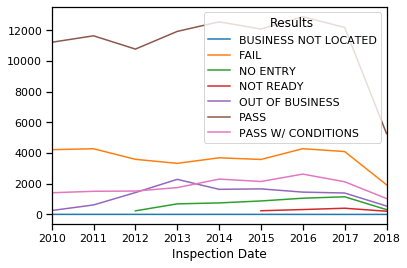

In [87]:
df.groupby([df['Inspection Date'].dt.year, df['Results']])['Results'].count().unstack().plot()

In [63]:
df['Results'].value_counts()

PASS                    100517
FAIL                     33008
PASS W/ CONDITIONS       16441
OUT OF BUSINESS          11289
NO ENTRY                  5076
NOT READY                 1176
BUSINESS NOT LOCATED        35
Name: Results, dtype: int64

### Are inspections requested by the establishments usually favorable?

Let's first take a look at the result distribution of this kind of inspection.

In [39]:
temp1 = df[df['Inspection Type'] == 'CONSULTATION']['Results']
temp1 = temp1.value_counts() / len(temp1) * 100
temp1

PASS                    63.509317
PASS W/ CONDITIONS      18.788820
FAIL                    15.527950
NO ENTRY                 0.931677
NOT READY                0.621118
OUT OF BUSINESS          0.465839
BUSINESS NOT LOCATED     0.155280
Name: Results, dtype: float64

For comparison, the same computation is done on the other types of inspection.

In [40]:
temp2 = df[df['Inspection Type'] != 'CONSULTATION']['Results']
temp2 = temp2.value_counts() / len(temp2) * 100
temp2

PASS                    59.981546
FAIL                    19.717432
PASS W/ CONDITIONS       9.778428
OUT OF BUSINESS          6.762214
NO ENTRY                 3.037784
NOT READY                0.702225
BUSINESS NOT LOCATED     0.020372
Name: Results, dtype: float64

In [41]:
(temp1 - temp2).sort_values(ascending=False)

PASS W/ CONDITIONS      9.010392
PASS                    3.527771
BUSINESS NOT LOCATED    0.134908
NOT READY              -0.081107
NO ENTRY               -2.106107
FAIL                   -4.189482
OUT OF BUSINESS        -6.296376
Name: Results, dtype: float64

In average, inspections requested by the establishments have a significantly higher success rate as well as a lower failing rate. TODO: elaborate answer

### What is the proportion of successful inspections needed in order to obtain a license? i.e. assess the difficulty to obtain such a license (per facility type).

In [45]:
show_all(df['Inspection Type'].value_counts())

CANVASS                                      87473
LICENSE                                      21849
CANVASS RE-INSPECTION                        17947
COMPLAINT                                    15787
LICENSE RE-INSPECTION                         7882
COMPLAINT RE-INSPECTION                       6473
SHORT FORM COMPLAINT                          6184
SUSPECTED FOOD POISONING                       746
CONSULTATION                                   644
TAG REMOVAL                                    602
LICENSE-TASK FORCE                             599
RECENT INSPECTION                              253
TASK FORCE LIQUOR 1475                         250
SUSPECTED FOOD POISONING RE-INSPECTION         171
COMPLAINT-FIRE                                 157
SHORT FORM FIRE-COMPLAINT                      113
OUT OF BUSINESS                                 96
NO ENTRY                                        66
PACKAGE LIQUOR 1474                             44
COMPLAINT-FIRE RE-INSPECTION   

### What is the evolution of the overall inspection frequency over the last decade?

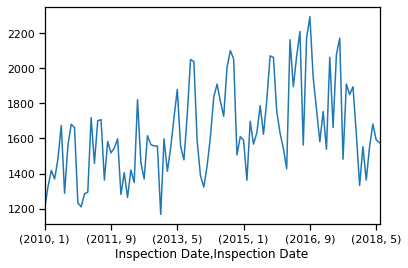

In [43]:
df['Inspection Date'].groupby([df['Inspection Date'].dt.year, df['Inspection Date'].dt.month]).agg('count').plot()

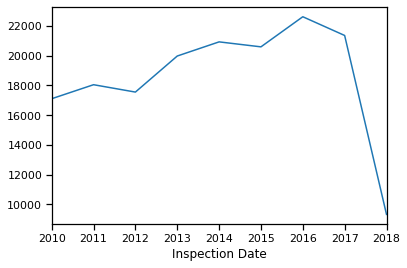

In [53]:
df['Inspection Date'].groupby(df['Inspection Date'].dt.year).agg('count').plot()

## Establishments' predispositions to inspection failure

<a id="predispositions"></a>

### Which facility type is more likely to fail?

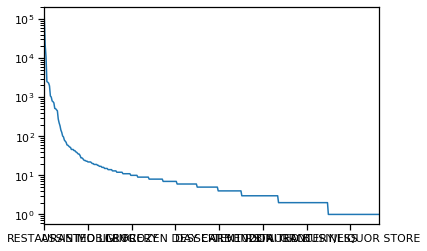

In [126]:
df['Facility Type'].value_counts().plot(logy=True)

In [120]:
# Filter out facility types that occur less than 50 times in the dataset
df_facility_results = df.groupby('Facility Type').filter(lambda x: x['Facility Type'].count()>50)

# For each facility type, compute the result frequencies
df_facility_results = df_facility_results.groupby(['Facility Type', 'Results'])['Results'].count().unstack().fillna(0)

# Normalize the frequencies in order to have comparable proportions
df_facility_results = df_facility_results['FAIL'] / df_facility_results.sum(axis=1)

# Print the 20 facility types with the highest fail rate
df_facility_results.sort_values(ascending=False).head(20)

Facility Type
LIQUOR                         0.359844
WHOLESALE                      0.340426
TAVERN                         0.336957
MOBILE FOOD PREPARER           0.297244
MOBILE FOOD DISPENSER          0.295511
LIVE POULTRY                   0.285714
GAS STATION                    0.269841
CONVENIENCE STORE              0.250000
MOBILE PREPARED FOOD VENDOR    0.240000
DAYCARE COMBO 1586             0.238095
GROCERY STORE                  0.237581
SPECIAL EVENT                  0.229167
KIOSK                          0.215686
BANQUET HALL                   0.215278
BANQUET                        0.214286
DAYCARE (UNDER 2 YEARS)        0.213636
LONG TERM CARE                 0.213420
BAKERY                         0.210463
DAYCARE (2 - 6 YEARS)          0.198262
SCHOOL                         0.194521
dtype: float64

### Are restaurants having already failed once more likely to fail again than the others? And are they more likely to close definitively?

### Compare the inspection results of the different food chain restaurant against themselves or other restaurants.

## Neighbourhood and food quality correlation

<a id="neighbourhood"></a>

### How are the inspection results evolving over time and space?

### Is there a relationship between the location of the restaurant and the quality? (economic and social causes)

### What is the most encountered violation category for each neighborhood?

## Violation analysis

<a id="violation"></a>

### What are the frequencies of each violation?

### Are some violations more frequent than others in an establishment’s failure?

### What are the most frequent violations encountered during complaint-caused inspections?